<a href="https://colab.research.google.com/github/vedanthshenoy/Infy-stock-price-prediction-BiLSTM/blob/main/infy_share_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
data=pd.read_csv('/content/drive/MyDrive/29-11-2018-TO-27-11-2020INFYALLN.csv',parse_dates=['Date'],index_col='Date')
data.head()

,Symbol,Series,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
Date,,,,,,,,,,,,,,
2018-11-29,INFY,EQ,666.40,671.00,674.90,658.80,665.00,661.05,667.03,13399070,8.937609e+09,170549,7390099,55.15
2018-11-30,INFY,EQ,661.05,661.00,672.00,660.95,670.00,667.45,667.52,10445773,6.972741e+09,118396,6667707,63.83
2018-12-03,INFY,EQ,667.45,673.15,679.00,665.95,672.45,670.35,670.58,8260890,5.539597e+09,103845,6137214,74.29
2018-12-04,INFY,EQ,670.35,672.55,688.25,671.30,683.00,685.25,682.83,7827923,5.345133e+09,129170,4357939,55.67
2018-12-05,INFY,EQ,685.25,683.00,683.65,672.50,682.05,681.40,678.97,5177288,3.515207e+09,96257,3101033,59.90


In [63]:
data['Day']=data.index.day
data['DayOfWeek']=data.index.dayofweek
data.head()

,Symbol,Series,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty,Day,DayOfWeek
Date,,,,,,,,,,,,,,,,
2018-11-29,INFY,EQ,666.40,671.00,674.90,658.80,665.00,661.05,667.03,13399070,8.937609e+09,170549,7390099,55.15,29,3
2018-11-30,INFY,EQ,661.05,661.00,672.00,660.95,670.00,667.45,667.52,10445773,6.972741e+09,118396,6667707,63.83,30,4
2018-12-03,INFY,EQ,667.45,673.15,679.00,665.95,672.45,670.35,670.58,8260890,5.539597e+09,103845,6137214,74.29,3,0
2018-12-04,INFY,EQ,670.35,672.55,688.25,671.30,683.00,685.25,682.83,7827923,5.345133e+09,129170,4357939,55.67,4,1
2018-12-05,INFY,EQ,685.25,683.00,683.65,672.50,682.05,681.40,678.97,5177288,3.515207e+09,96257,3101033,59.90,5,2


In [64]:
data.drop(columns=['Symbol','Series'],inplace=True)
data.head()

,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty,Day,DayOfWeek
Date,,,,,,,,,,,,,,
2018-11-29,666.40,671.00,674.90,658.80,665.00,661.05,667.03,13399070,8.937609e+09,170549,7390099,55.15,29,3
2018-11-30,661.05,661.00,672.00,660.95,670.00,667.45,667.52,10445773,6.972741e+09,118396,6667707,63.83,30,4
2018-12-03,667.45,673.15,679.00,665.95,672.45,670.35,670.58,8260890,5.539597e+09,103845,6137214,74.29,3,0
2018-12-04,670.35,672.55,688.25,671.30,683.00,685.25,682.83,7827923,5.345133e+09,129170,4357939,55.67,4,1
2018-12-05,685.25,683.00,683.65,672.50,682.05,681.40,678.97,5177288,3.515207e+09,96257,3101033,59.90,5,2


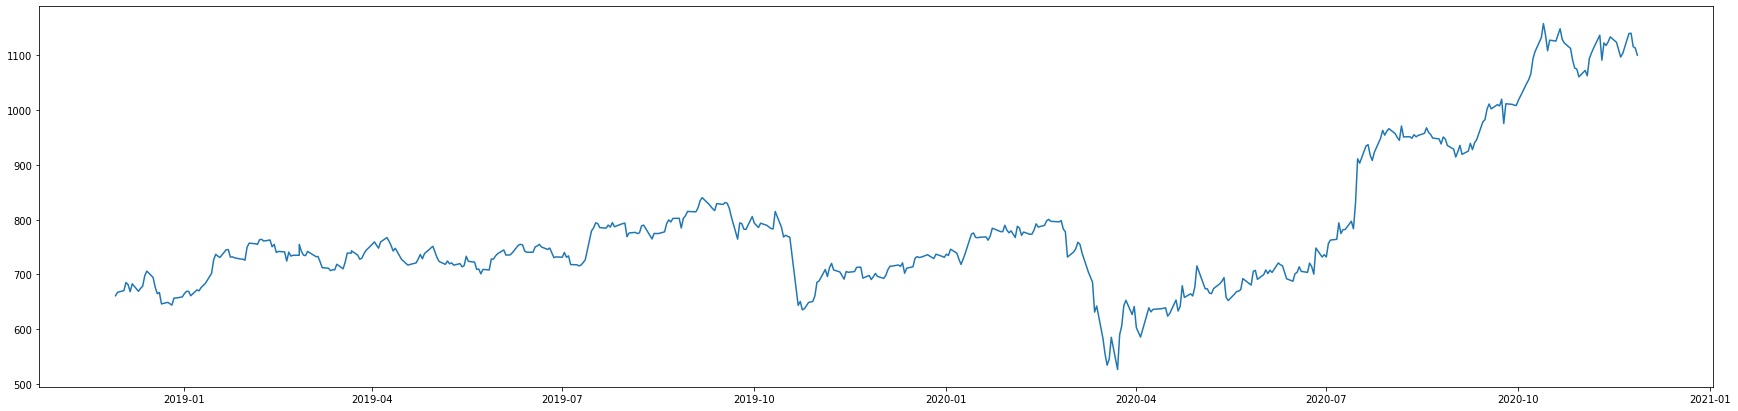

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,7))
plt.plot(data.index,data['Close Price'])
plt.show()

In [66]:
train_size=int(len(data)*0.9)
train,test=data.iloc[:train_size],data.iloc[train_size:len(data)]
train.shape,test.shape

((449, 14), (50, 14))

In [67]:
from sklearn.preprocessing import MinMaxScaler

rs_data = MinMaxScaler()
rs_target = MinMaxScaler()

target=data['Close Price']
data.drop(columns=['Close Price'],inplace=True)

train.loc[:,data.columns]=rs_data.fit_transform(train.loc[:,data.columns].to_numpy())
train['Close Price']=rs_target.fit_transform(train[['Close Price']].to_numpy())
test.loc[:,data.columns]=rs_data.fit_transform(test.loc[:,data.columns].to_numpy())
test['Close Price']=rs_target.fit_transform(test[['Close Price']].to_numpy())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [68]:
import numpy as np
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [69]:
time_steps=10

x_train, y_train = create_dataset(train, train['Close Price'], time_steps)
x_test, y_test = create_dataset(test, train['Close Price'], time_steps)

x_train.shape,x_test.shape

((439, 10, 14), (40, 10, 14))

In [70]:
import keras
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,return_sequences=True
    )
  ))
model.add(
  keras.layers.Bidirectional(
  keras.layers.LSTM(
  units=500,return_sequences=True
    )
  ))
model.add(
  keras.layers.Bidirectional(
  keras.layers.LSTM(units=500)
  )
)
model.add(keras.layers.Dropout(rate=0.25))
model.add(keras.layers.Dense(units=100,activation='relu'))
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(units=1))
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=["mse"])

In [71]:
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.35,
    shuffle=False,
    verbose=1
)

Epoch 1/10
9/9 [==============================] - 9s 993ms/step - loss: 0.0737 - mse: 0.1475 - val_loss: 0.0191 - val_mse: 0.0382
Epoch 2/10
9/9 [==============================] - 7s 742ms/step - loss: 0.0083 - mse: 0.0165 - val_loss: 0.0149 - val_mse: 0.0298
Epoch 3/10
9/9 [==============================] - 7s 749ms/step - loss: 0.0038 - mse: 0.0076 - val_loss: 0.0124 - val_mse: 0.0247
Epoch 4/10
9/9 [==============================] - 7s 747ms/step - loss: 0.0028 - mse: 0.0056 - val_loss: 0.0105 - val_mse: 0.0210
Epoch 5/10
9/9 [==============================] - 7s 744ms/step - loss: 0.0025 - mse: 0.0050 - val_loss: 0.0098 - val_mse: 0.0196
Epoch 6/10
9/9 [==============================] - 7s 745ms/step - loss: 0.0022 - mse: 0.0044 - val_loss: 0.0096 - val_mse: 0.0193
Epoch 7/10
9/9 [==============================] - 7s 744ms/step - loss: 0.0021 - mse: 0.0043 - val_loss: 0.0099 - val_mse: 0.0198
Epoch 8/10
9/9 [==============================] - 7s 748ms/step - loss: 0.0022 - mse: 0.00

In [74]:
pred=model.predict(x_test)
y_train_inv=rs_target.inverse_transform(y_train.reshape(1,-1))
y_test_inv=rs_target.inverse_transform(y_test.reshape(1,-1))
pred=rs_target.inverse_transform(pred.reshape(1,-1))

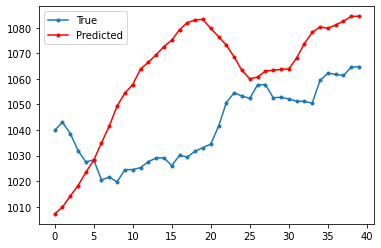

In [75]:
plt.plot(y_test_inv.flatten(),marker='.',label='True')
plt.plot(pred.flatten(),'r',marker='.',label='Predicted')
plt.legend()
plt.show()